# モデル品質モニタリングのステップB

このノートブックを実行する時のヒント：  
- このノートブックは大容量のRawデータを読み込むため、<span style="color: orange; ">メモリー8GB以上のインスタンス</span>で実行してください
- KernelはPython3（Data Science）で動作確認をしています。
- デフォルトではSageMakerのデフォルトBucketを利用します。必要に応じて変更することも可能です。
- 実際に動かさなくても出力を確認できるようにセルのアウトプットを残しています。きれいな状態から実行したい場合は、右クリックメニューから "Clear All Outputs"を選択して出力をクリアしてから始めてください。
- 作成されたスケジュールはSageMaker Studioの`SageMaker resource` （左側ペインの一番下）のEndpointメニューからも確認可能

複数のノートブックで共通で使用する変数

In [2]:
# エンドポイント名を指定する
endpoint_name = 'nyctaxi-xgboost-endpoint'

# エンドポイントConfigの名前を指定する
endpoint_config_name = f'{endpoint_name}-config'

# データ品質のモニタリングスケジュールの名前を指定する
model_quality_monitoring_schedule = f'{endpoint_name}-model-quality-schedule'

# SageMaker default bucketをModel Monitorのバケットとして使用
# それ以外のバケットを使用している場合はここで指定する
import sagemaker
bucket = sagemaker.Session().default_bucket()

モニタリング結果を保管するための、ベースラインやレポートのS3上のPrefixを設定します

## B1（オプションA） 推論を実行してGround TruthをS3にアップロードする
推論の実行後に次の周期のモニタリングジョブを待つ必要があります

In [5]:
# ベースラインの出力先Prefixを設定する
baseline_prefix = 'model_monitor/model_quality_baseline'

# 時系列での可視化のために、複数のレポートに共通するPrefixを設定する
report_prefix = 'model_monitor/model_quality_monitoring_report'

# Ground Truthをアップロードする先のPrefixを指定します
ground_truth_prefix = 'model_monitor/model_quality_ground_truth'

### Inference IDを指定して推論を実行する

In [6]:
# 推論を実行する日付を指定する
prediction_target_date = '2021-09-15'

# データのサンプリングレートを指定する（モデル作成時の設定に合わせる）
sampling_rate = 20

# 推論結果を保存するディレクトリ名を指定する
result_dir = 'prediction_results_model_quality'

In [7]:
import os
import boto3
import pandas as pd
import time
from datetime import datetime
import model_utils

In [8]:
def get_data_for_pred(target, sampling_rate):
    previous_year, previous_month = model_utils.get_previous_year_month(target.year, target.month)
    df_previous_month = model_utils.get_raw_data(previous_year, previous_month, sampling_rate)
    df_current_month = model_utils.get_raw_data(target.year, target.month, sampling_rate)
    df_data = pd.concat([df_previous_month, df_current_month])
    del df_previous_month
    del df_current_month

    # Extract features
    df_features = model_utils.extract_features(df_data)
    df_features = model_utils.filter_current_month(df_features, target.year, target.month)
    
    return df_features

In [9]:
# Create result directory if not exist
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

target_date = pd.to_datetime(prediction_target_date)
print('Loading data for', target_date.strftime('%Y-%m'))
df_features = get_data_for_pred(target_date, sampling_rate)
        
# Exec prediction for the target date
print('Predicting', target_date, endpoint_name)
df_pred = df_features[df_features.index == target_date].copy()
df_pred[['pred', 'inference_id']] = model_utils.exec_prediction(endpoint_name, df_pred)

# Save prediction result
result_file = f'{result_dir}/prediction-result-{prediction_target_date}.csv'
df_pred.to_csv(result_file, index=False)
print('Prediciton completed. Result file: ', result_file)

Loading data for 2021-09
Predicting 2021-09-15 00:00:00 nyctaxi-xgboost-endpoint
Prediciton completed. Result file:  prediction_results_model_quality/prediction-result-2021-09-15.csv


### 推論時に取得したInference IDとGround TruthをマージしてS3にアップロードする

In [10]:
import sagemaker
import boto3
import pandas as pd
import io
import json
import sagemaker
from sagemaker.s3 import S3Uploader
from datetime import datetime

s3r = boto3.resource('s3')

In [11]:
# Ground Truth（今回はpickup_countカラム）および、inference id（今回はinference_id）が格納されたファイルを取得する
# ここではローカルファイルのcsvに1日分の推論実行結果が保存されており、Ground TruthとInferenceが同一ファイルに格納されていると想定する。
ground_truth_colname = 'pickup_count'
inference_id_colname = 'inference_id'

# Ground TruthをアップロードするPrefixを設定
# create_monitoring_scheduleを実行した際のモニタリングジョブの設定と一致させる
bucket = sagemaker.Session().default_bucket()
ground_truth_path = f's3://{bucket}/{ground_truth_prefix}'

In [12]:
# Ground Truthの収集
df_prediction = pd.read_csv(result_file)
df_prediction.head(3)

,pickup_count,history_12slots,history_16slots,history_20slots,history_24slots,history_28slots,history_32slots,history_36slots,history_40slots,history_44slots,...,tolls_amount_mean_20slot,tolls_amount_mean_96slot,tolls_amount_mean_100slot,tolls_amount_mean_104slot,tolls_amount_mean_192slot,tolls_amount_mean_196slot,tolls_amount_mean_200slot,time_slot,pred,inference_id
0,113,264.0,324.0,350.0,359.0,369.0,362.0,352.0,301.0,294.0,...,0.352771,0.440594,0.674265,0.203778,0.169022,0.544014,0.699157,0,88,f7642aa4-4496-43be-9185-89e9cfe14c53
1,91,249.0,274.0,330.0,391.0,351.0,320.0,343.0,340.0,279.0,...,0.277879,0.786000,0.751639,0.463443,0.883146,0.681200,0.872543,1,71,a0911496-6e3e-4984-84e2-349152581687
2,81,273.0,270.0,327.0,405.0,376.0,363.0,333.0,316.0,298.0,...,0.260398,0.777119,0.564286,0.536010,1.105844,0.661009,0.595752,2,72,bed71a18-4006-461d-863d-e9c1ec7e65d6


In [13]:
# Ground TruthとInference IDを開発者ガイドで定義されたフォーマットに変換する
# https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-merge.html
def ground_truth_with_id(ground_truth, inference_id):
    return {
        "groundTruthData": {
            "data": str(ground_truth),
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }

推論したデータの前半に対しては、すぐにGround Truthが付与されたと仮定して、Ground Truthをアップロードする

In [14]:
# Prediction結果をjsonに変換し、jsonlとしてstring化する
gt_records = df_prediction.iloc[:int(df_prediction.shape[0]/2)].apply(lambda x: json.dumps(ground_truth_with_id(x[ground_truth_colname], x[inference_id_colname])), axis=1)
gt_jsonl = '\n'.join(gt_records)

# StringをS3のground truth inputにアップロードする
upload_time = datetime.now().strftime('%Y/%m/%d/%H')
target_s3_uri = f'{ground_truth_path}/{upload_time}/ground_truth.jsonl'
S3Uploader.upload_string_as_file_body(gt_jsonl, target_s3_uri)

's3://sagemaker-ap-northeast-1-370828233696/model_monitor/model_quality_ground_truth/2022/12/16/10/ground_truth.jsonl'

推論したデータの後半に対しては、Ground Truthの付与に1時間かかったと仮定して、3600秒後にGround Truthをアップロードする

In [15]:
time.sleep(3600)
# Prediction結果をjsonに変換し、jsonlとしてstring化する
gt_records = df_prediction.iloc[int(df_prediction.shape[0]/2):].apply(lambda x: json.dumps(ground_truth_with_id(x[ground_truth_colname], x[inference_id_colname])), axis=1)
gt_jsonl = '\n'.join(gt_records)

# StringをS3のground truth inputにアップロードする
upload_time = datetime.now().strftime('%Y/%m/%d/%H')
target_s3_uri = f'{ground_truth_path}/{upload_time}/ground_truth.jsonl'
S3Uploader.upload_string_as_file_body(gt_jsonl, target_s3_uri)

's3://sagemaker-ap-northeast-1-370828233696/model_monitor/model_quality_ground_truth/2022/12/16/11/ground_truth.jsonl'

- ここまでの実行で推論の実行とGround Truthのアップロードが完了しました
- 次の時間の0分から20分の間にモデル品質のモニタリングジョブが稼働し、モニタリングレポートが出力されます

## B1 （オプションB） モニタリングの実行をまたずにサンプルで分析してみる
モニタリング結果の分析では、複数のモニタリング周期にまたがる精度の推移を可視化します。複数のモニタリング周期にまたがってレポートを出力するには時間がかかるため、サンプルコードに含まれるレポートで分析や可視化を試したい場合は、以下のセルを実行してS3バケットにサンプルのレポートをアップロードしてください  
ご自身のレポートで可視化を行う場合は、このセルはスキップしてください

In [3]:
sagemaker.s3.S3Uploader.upload('model_quality_samples', f's3://{bucket}/model_monitor/model_quality_samples')

baseline_prefix = 'model_monitor/model_quality_samples/baseline'
report_prefix = 'model_monitor/model_quality_samples/reports'
specific_report_prefix = 'model_monitor/model_quality_samples/reports/2020/03/16/01'

# B2. モニタリング結果の分析

分析の実行

In [4]:
import sagemaker
from sagemaker import model_monitor
import boto3
import pandas as pd

In [5]:
def get_reports(report_bucket, report_location, file_type):
    s3 = boto3.client('s3')
    assert file_type in ('statistics', 'constraints', 'violations')
    
    resp = s3.list_objects(Bucket=report_bucket, Prefix=report_location)
    report_files = [x['Key'] for x in resp['Contents'] if x['Key'].endswith(f'{file_type}.json')]

    monitoring_reports = {}
    for key in sorted(report_files):
        report_s3uri = f's3://{report_bucket}/{key}'
        
        if file_type == 'statistics':
            body_dict = model_monitor.Statistics.from_s3_uri(report_s3uri).body_dict
        elif file_type == 'constraints':
            body_dict = model_monitor.Constraints.from_s3_uri(report_s3uri).body_dict
        elif file_type == 'violations':
            body_dict = model_monitor.ConstraintViolations.from_s3_uri(report_s3uri).body_dict
        else:
            print('Unexpected file type')
            return 
        
        report_time = pd.to_datetime('-'.join(key.split('/')[-5:-1]), format='%Y-%m-%d-%H')
        monitoring_reports[report_time] = body_dict

    return monitoring_reports

In [6]:
def extract_stats_value(statistics_reports, metric_type):
    
    all_values = {}
    for key, report in statistics_reports.items():    
        report_values = {}
        for metric_name, metric_value_dict in report[metric_type].items():
            report_values[metric_name] = metric_value_dict['value']
                
        all_values[key] = report_values

    df = pd.DataFrame(all_values).transpose()
    return df

### 精度メトリクスを時系列でDataFrame化する

In [7]:
# Statisticsレポートを取得
statistics_reports = get_reports(bucket, report_prefix, 'statistics')

# 特定のmetricを取得
df_regression_metrics = extract_stats_value(statistics_reports, 'regression_metrics')
df_regression_metrics

,mae,mse,rmse,r2
2020-01-06 01:00:00,48.736082,3559.985828,59.665617,0.915222
2020-01-13 01:00:00,33.640843,2203.995053,46.946726,0.959612
2020-01-20 01:00:00,56.177981,5339.805945,73.073976,0.840637
2020-01-27 01:00:00,32.058851,1598.723379,39.984039,0.966500
2020-02-03 01:00:00,39.323701,2523.980451,50.239232,0.948893
2020-02-10 01:00:00,41.485255,2958.223253,54.389551,0.949442
2020-02-17 01:00:00,47.202256,3553.185067,59.608599,0.865158
2020-02-24 01:00:00,39.585234,2842.260041,53.312851,0.942540
2020-03-02 01:00:00,41.083948,2872.077381,53.591766,0.942076
2020-03-09 01:00:00,61.858424,7275.347270,85.295646,0.812754


### 取得した精度メトリクスを時系列でグラフ化

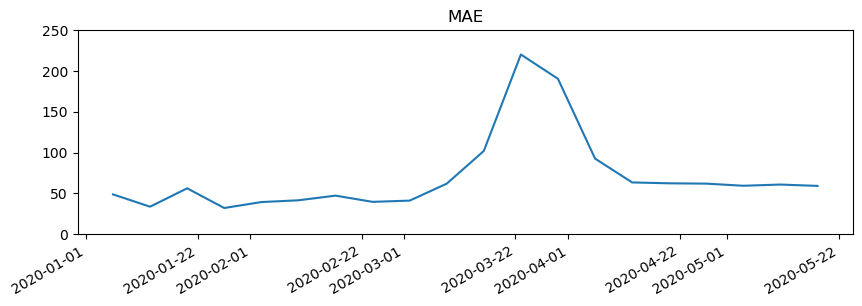

In [8]:
%matplotlib inline
metric = 'mae'
df_regression_metrics[metric].plot(ylim=(0,250), figsize=(10,3), title=metric.upper())

### 同じ期間のGround Truthと予測結果を比較する
※ 「B1 オプションB」を選択した場合は推論結果がローカルに保存されていないため、実行できません。スキップしてください

In [ ]:
import glob

values = {}
prediction_result_files = glob.glob(f'./{result_dir}/*.csv')
for file in prediction_result_files:
    df_pred = pd.read_csv(file)
    pred_date = pd.to_datetime('-'.join(file.split('.')[-2].split('-')[-3:]))
    values[pred_date] = df_pred[['pickup_count', 'pred']].mean().to_dict()
    
df_gt = pd.DataFrame(values).transpose().sort_index()
df_regression_metrics = pd.merge(df_regression_metrics, df_gt, how='inner', left_index=True, right_index=True)
df_regression_metrics.head(3)

In [ ]:
df_regression_metrics[['pickup_count', 'pred']].plot(figsize=(10,3), title='Taxi Pickup Count Per Hour (mean)')

# 参考コード

### 参考｜キャプチャしたデータからinferenceIdを収集する
データキャプチャ時にサンプリングしている場合は、キャプチャ対象となった推論リクエストを特定するためキャプチャされたレコードを取得する  

In [ ]:
bucket_name = sagemaker.Session().default_bucket()
capture_data_key = 'model_monitor/endpoint-data-capture/nyctaxi-endpoint/AllTraffic/2022/12/11/07/27-10-902-c1277fdc-38a1-407e-b96d-3921ed423787.jsonl'

In [20]:
s3r_bucket = s3r.Bucket(bucket_name)
capture_data = s3r_bucket.Object(capture_data_key).get()['Body'].read().decode('utf-8')

df_capture = pd.read_json(io.StringIO(capture_data), lines=True)
df_inference_id = pd.json_normalize(df_capture['eventMetadata'])
df_inference_id

,eventId,inferenceId,inferenceTime
0,dcbf4055-1196-4b71-ab54-e290b4b3530e,50f38bbc-1c15-4d81-ac2a-7a922d8adef6,2022-12-11T07:27:10Z
1,53b77003-449e-4ee9-9eea-88ac0b66df40,b5d9a7ac-9eaf-4fa4-8549-c4b1e2c78492,2022-12-11T07:27:10Z
2,07e28837-40c6-4731-a1fa-dcdfbf543ec6,20b5e6f6-0b84-44fc-8977-68da623391d1,2022-12-11T07:27:11Z
3,3004ec50-6b30-4043-b149-76e3322016cd,37b11b6d-1087-4378-948d-247a86da68f6,2022-12-11T07:27:11Z
4,9336b2ff-dea3-4095-9d9c-f882cab4e7b3,f6bed701-025d-4aac-9941-c90e9ede4509,2022-12-11T07:27:11Z
...,...,...,...
83,eb42e34b-93e5-46e5-9f28-68807f93348c,db5843e2-a983-4a19-b6fe-ae6c8a321ce9,2022-12-11T07:27:15Z
84,72846ebd-4f6b-4571-9f09-554d792f5609,190dbd03-4479-4706-bbe0-0b101e1a6fe2,2022-12-11T07:27:15Z
85,bddc4048-e81c-4bbf-be19-d2359f5d8a0b,bf1842fd-2884-4f2b-9932-8a2acb9b754c,2022-12-11T07:27:15Z
86,38c518b2-5d79-4cd6-94b6-6497bb9e992b,fb6c7636-cce2-4727-a79e-599ea8c1fd1d,2022-12-11T07:27:15Z
